In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime

# General overview

In [2]:
pr_lifespan = pd.read_csv('./data/pr_avg_lifespan_2016_2018.csv', parse_dates=['month'])
pr_lifespan.head()

,name,month,count,lifespan
0,2dxgujun/AndroidTagGroup,2016-01-01,1,150061.0
1,500px/500px-android-blur,2016-02-01,3,16628.0
2,500px/500px-android-blur,2016-10-01,1,147.0
3,500px/500px-android-blur,2017-08-01,2,438.5
4,81813780/AVLoadingIndicatorView,2016-01-01,2,2.0


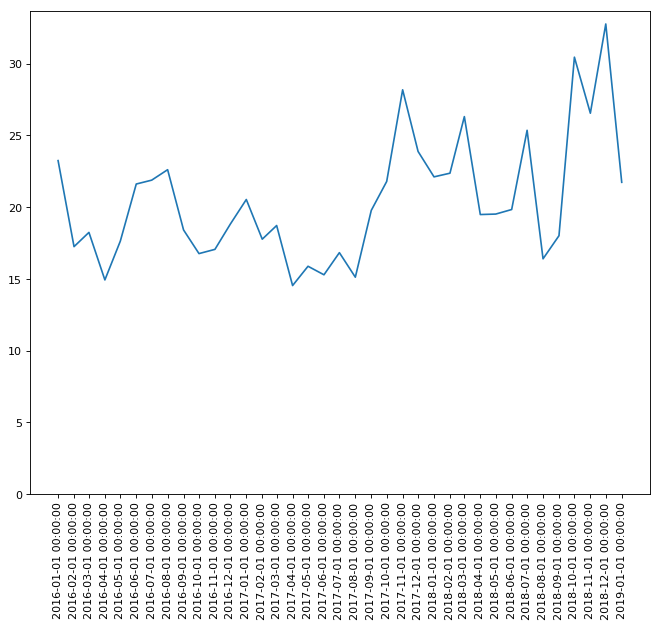

In [3]:
wm = lambda x: np.average(x, weights=pr_lifespan.loc[x.index, "count"])
f = {'count': ['sum'], 'lifespan' : wm }
avg_weighted = pr_lifespan.groupby(["month"]).agg(f)

plt.figure(figsize=(10, 8), dpi=80)
plt.plot(avg_weighted.index.tolist(), avg_weighted['lifespan'] / 60 / 24)
plt.ylim(0)
plt.xticks(avg_weighted.index.tolist(), avg_weighted.index.tolist(), rotation='vertical')
plt.show()

In [4]:
def plot_pr_lifespan(*repos):
    data = []
    for repo in repos:
        pr_lt = pr_lifespan.loc[pr_lifespan['name'] == repo]
        data += [pr_lt['month'], pr_lt['lifespan'] / 60 / 24]
    plt.figure(figsize=(10, 8), dpi=80)
    plt.plot(*data)
    plt.ylim(0)
    plt.xticks(avg_weighted.index.tolist(), avg_weighted.index.tolist(), rotation='vertical')
    plt.legend(repos)
    plt.show()

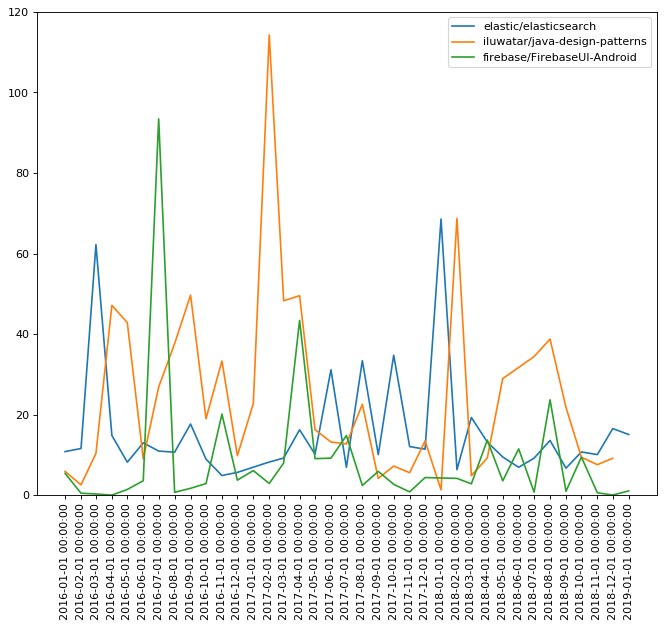

In [5]:
plot_pr_lifespan('elastic/elasticsearch', 'iluwatar/java-design-patterns', 'firebase/FirebaseUI-Android')

## Average time 

In [6]:
wm = lambda x: np.average(x, weights=pr_lifespan.loc[x.index, "count"])
f = {'count': ['sum'], 'lifespan' : wm }
avg_lifespan = pr_lifespan.groupby('name').agg(f)
avg_lifespan.head()

,count,lifespan
,sum,<lambda>
name,,
2dxgujun/AndroidTagGroup,1,150061.000000
500px/500px-android-blur,6,8484.666667
81813780/AVLoadingIndicatorView,10,133032.000000
ACRA/acra,144,15075.736111
AbrahamCaiJin/CommonUtilLibrary,4,2078.000000


## Export data to json

In [14]:
from math import isnan
repo_list = set(pr_lifespan.loc[:,'name'])
data = {
    repo:{
        'lifespan':{},
        'avg_lifespan':avg_lifespan.loc[repo]['lifespan']['<lambda>'] if not isnan(avg_lifespan.loc[repo]['lifespan']['<lambda>']) else 0,
        'total_count':avg_lifespan.loc[repo]['count']['sum']
    }
    for repo in repo_list
}
for index, line in pr_lifespan.iterrows():
    if str(line['month']) != 'NaT' and line['lifespan']:
        data[line['name']]['lifespan'][str(line['month'])] = {
            'lifespan':line['lifespan'],
            'count':line['count'],
        }

In [15]:
import json 

with open('./data/pr_avg_lifespan_2016_2018.json', 'w+') as f:
    json.dump(data, f)

# Case study of jenkinsci/jenkins

In [6]:
pr_jenkins = pd.read_csv('./data/pr/jenkinsci_jenkins.csv', parse_dates=['created_at', 'closed_at', 'merged_at']).dropna(subset=['created_at', 'closed_at'])
pr_jenkins = pr_jenkins.sort_values(by=['closed_at']).reset_index(drop=True)
                
pr_jenkins.head()

,name,created_at,closed_at,lifespan,pr_id,merged_at,merged,created_by,closed_by
0,jenkinsci/jenkins,2015-12-21 15:38:02,2016-01-04 16:19:16,20201.0,1960,"""2016-01-04T16:19:16Z""",True,varmenise,varmenise
1,jenkinsci/jenkins,2015-09-08 10:07:38,2016-01-05 10:52:52,171405.0,1822,nan,False,tfennelly,tfennelly
2,jenkinsci/jenkins,2014-01-26 04:48:37,2016-01-05 22:59:52,1022051.0,1102,nan,False,ikedam,ikedam
3,jenkinsci/jenkins,2015-04-11 02:02:53,2016-01-05 23:02:52,388620.0,1643,nan,False,ikedam,ikedam
4,jenkinsci/jenkins,2013-10-28 13:59:03,2016-01-05 23:21:26,1151122.0,988,nan,False,ikedam,ikedam


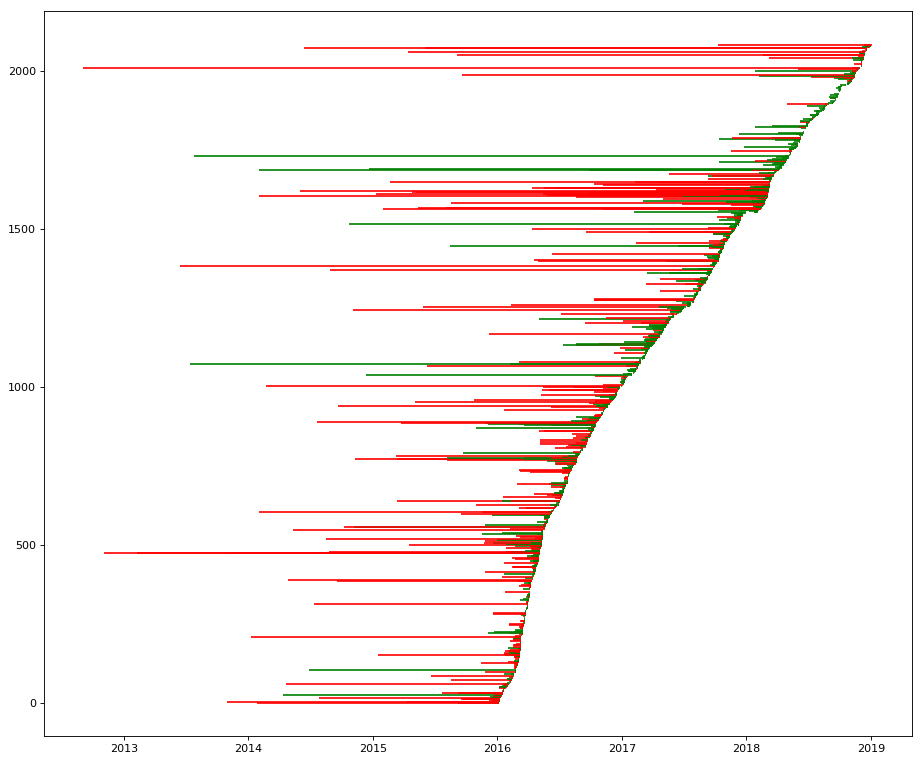

In [7]:
fig, ax = plt.subplots(figsize=(14, 12), dpi=80)

for i, row in pr_jenkins.iterrows():
    color = 'r'
    if row['merged']:
        color = 'g'
    ax.hlines(i, xmin=row['created_at'], xmax=row['closed_at'], color=color)

plt.show()

In [8]:
pr_jenkins.groupby(["merged"]).describe()['lifespan']

,count,mean,std,min,25%,50%,75%,max
merged,,,,,,,,
False,723.0,154835.124481,375480.724250,0.0,1297.5,8648.0,75751.0,3278068.0
True,1363.0,32385.571533,147488.356953,2.0,1479.0,5256.0,15500.5,2514433.0


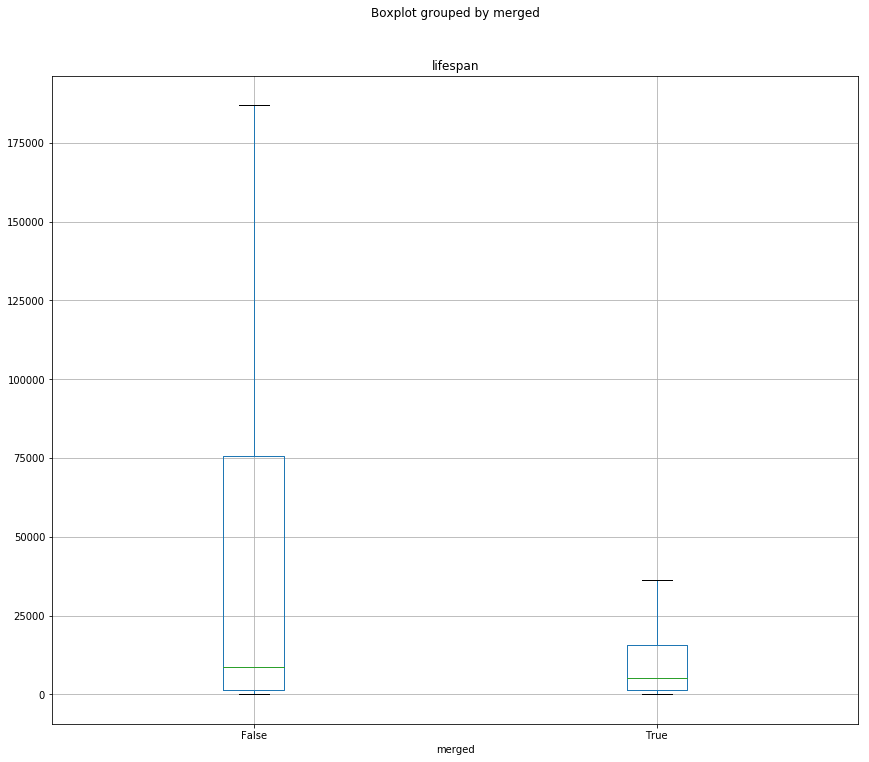

In [9]:
pr_jenkins.boxplot(column='lifespan', by='merged', showfliers=False, figsize=(14, 12))

In [10]:
closed_by_count = pr_jenkins.closed_by.value_counts()
top_pr_closer = closed_by_count[closed_by_count > 10].index
only_top_pr_closer = pr_jenkins[pr_jenkins['closed_by'].isin(top_pr_closer)]

In [11]:
only_top_pr_closer.groupby(["closed_by"]).describe()['lifespan']

,count,mean,std,min,25%,50%,75%,max
closed_by,,,,,,,,
KostyaSha,13.0,186420.692308,178122.336629,90.0,37472.00,117775.0,420753.00,421585.0
abayer,14.0,74756.857143,194490.388020,21.0,251.75,3719.0,10425.25,727077.0
batmat,104.0,117200.538462,395937.377514,16.0,1102.00,3144.5,17100.50,2380599.0
daniel-beck,396.0,77666.194444,257747.700534,1.0,1414.50,5254.0,22532.75,1978414.0
fbelzunc,18.0,156470.833333,358945.592806,994.0,5248.25,43592.0,87622.00,1486450.0
jglick,138.0,41818.579710,213734.014465,3.0,921.00,2478.5,8628.00,2259637.0
jtnord,17.0,19586.117647,62596.901190,16.0,545.00,1378.0,3135.00,258013.0
kohsuke,59.0,26493.847458,116583.538648,5.0,253.50,2624.0,6568.00,873116.0
kzantow,33.0,71311.000000,186898.198293,116.0,4007.00,9422.0,31154.00,782213.0


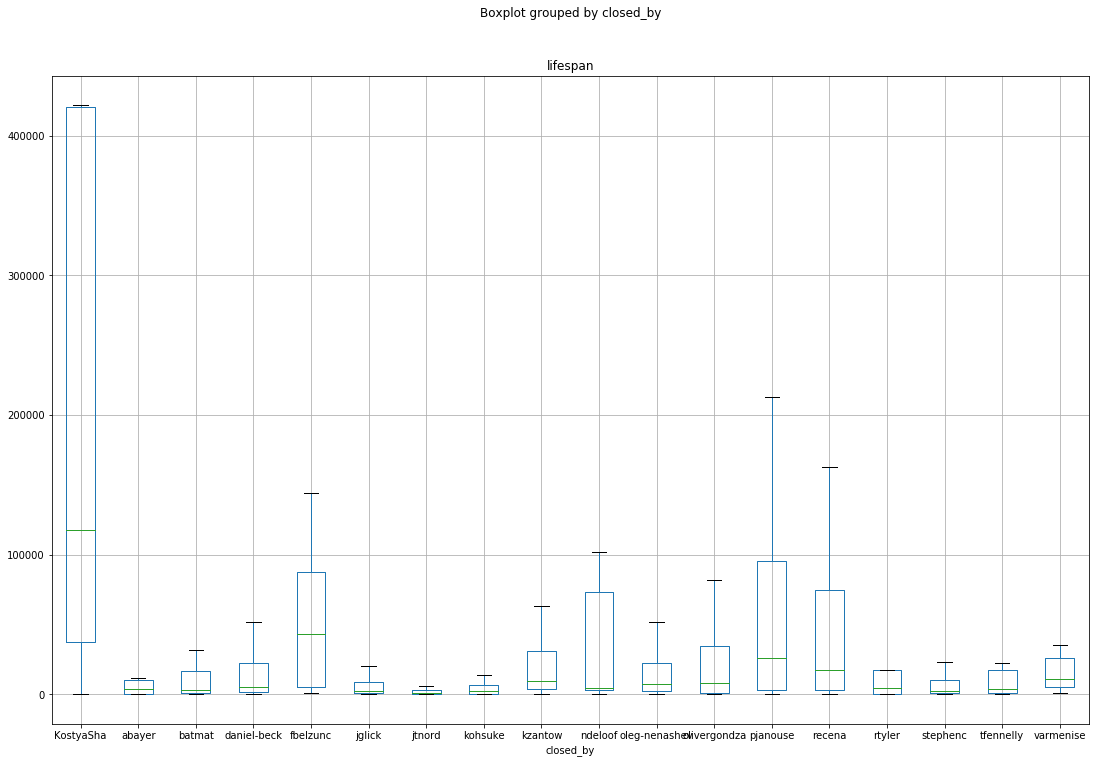

In [13]:
only_top_pr_closer.boxplot(column='lifespan', by='closed_by', showfliers=False, figsize=(18, 12))
plt.show()